In [13]:
import joblib
from darts import TimeSeries
# ^^^ pyforest auto-imports - don't write above this line
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from egbz.utils import *

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

# Data loading

In [3]:
dataset = joblib.load('../training_data/dataset.pkl')
t_dataset = joblib.load('../training_data/t_dataset.pkl')
c_dataset = joblib.load('../training_data/c_dataset.pkl')
dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<xarray.Dataset>
Dimensions:        (time: 606, zone: 101)
Coordinates:
  * zone           (zone) object '01' '02' '03' '04' ... '974' '976' 'france'
  * time           (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2021-08-28
Data variables: (12/58)
    tpauv          (zone) float64 10.7 18.9 15.5 16.4 14.3 ... nan nan nan nan
    talloc         (zone) float64 2.3 7.5 6.1 5.0 3.6 ... nan nan nan nan nan
    smok           (zone) float64 0.262 0.305 0.262 0.321 ... nan nan nan nan
    ALD1           (zone) float64 814.0 782.0 918.0 804.0 ... 1.132e+03 nan nan
    ALD2           (zone) float64 47.0 45.0 52.0 54.0 64.0 ... 18.0 33.0 nan nan
    ALD3           (zone) float64 841.0 1.003e+03 1.09e+03 ... 630.0 nan nan
    ...             ...
    reg_incid_rea  (zone, time) float64 nan nan nan nan nan ... nan nan nan nan
    pos            (zone, time) float64 nan nan nan ... 1.881e+04 1.881e+04
    pos_7j         (zone, time) float64 nan nan nan ... 1.33e+05 1.33e+05
    conf           (zone, time) float64 nan nan nan ... 6.711e+06 6.729e+06
    esms_dc        (zone, time) float64 nan nan nan ... 2.65e+04 2.65e+04
    dc_tot         (zone, time) float64 nan nan nan ... 1.116e+05 1.116e+05

In [4]:
mdep = [x for x in dataset.zone.values
        if x not in ['france', '971', '972', '973', '974','976']]

Voici le dataset maximum sans valeurs manquantes :'( :

In [5]:
data = (dataset
    .sel(zone=mdep, time=slice('2020-06-12','2021-04-21'))
    .drop_vars(names=['conf','esms_dc', 'dc_tot'])
)

In [3]:
joblib.dump(data, '../data.dataset')

<IPython.core.display.Javascript object>

NameError: name 'data' is not defined

# Univariate PolynamialTrend

In [10]:
from sktime.forecasting.trend import PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=3)
y = data['hosp'].sel(zone='75').to_dataframe()['hosp']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

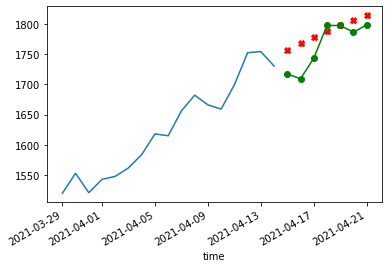

In [11]:
lookback=50
for i in range(1, 8):
    forecaster = PolynomialTrendForecaster(degree=3)
    train = y.iloc[-lookback-7:-7]
    forecaster.fit(train, fh=i)
    y_pred = forecaster.predict()
    plt.plot(y_pred, c='red', marker='X');
y.iloc[290:-7].plot();
y.iloc[-7:].plot(label='label', color='green', marker='o');

In [16]:
def objective(trial):
    forecaster = PolynomialTrendForecaster(
        degree=trial.suggest_int('degree', 1, 25)
    )
    train = y.iloc[trial.suggest_int('lookback',-100, -1)-7:-7]
    forecaster.fit(train, fh=7)
    y_pred = forecaster.predict()
    
    return abs(y.iloc[-1] - y_pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [347]:
study.trials_dataframe().sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_degree,params_lookback,state
894,894,3.229114e-01,2021-08-29 22:51:53.203995,2021-08-29 22:51:53.224411,0 days 00:00:00.020416,4,-50,COMPLETE
670,670,3.229114e-01,2021-08-29 22:51:48.593668,2021-08-29 22:51:48.610419,0 days 00:00:00.016751,4,-50,COMPLETE
674,674,3.229114e-01,2021-08-29 22:51:48.666538,2021-08-29 22:51:48.683088,0 days 00:00:00.016550,4,-50,COMPLETE
679,679,3.229114e-01,2021-08-29 22:51:48.767658,2021-08-29 22:51:48.786157,0 days 00:00:00.018499,4,-50,COMPLETE
683,683,3.229114e-01,2021-08-29 22:51:48.846018,2021-08-29 22:51:48.862747,0 days 00:00:00.016729,4,-50,COMPLETE
...,...,...,...,...,...,...,...,...
926,926,2.263959e+07,2021-08-29 22:51:53.908063,2021-08-29 22:51:53.927618,0 days 00:00:00.019555,22,-45,COMPLETE
998,998,6.129670e+07,2021-08-29 22:51:55.439458,2021-08-29 22:51:55.459533,0 days 00:00:00.020075,24,-43,COMPLETE
793,793,6.258914e+07,2021-08-29 22:51:51.043929,2021-08-29 22:51:51.062466,0 days 00:00:00.018537,25,-45,COMPLETE
509,509,1.576261e+08,2021-08-29 22:51:45.743190,2021-08-29 22:51:45.758739,0 days 00:00:00.015549,22,-34,COMPLETE


Ok, mais qu'est-ce que ça donne avec une Cross-val ? Définissons une fonction de cross validation sur des fenêtres glissantes.

In [111]:
def sliding_cross_val_score(
    y,
    estimator=None,
    fh=1,
    step_length= 1,
    lookback=1,
    initial_shift=30,
    verbose=False
) -> np.array:
    """
    Given a time serie *y* and an estimator returns an array
    of the scores of this estimator trained on sliding windows
    over y.
    
    Parameters

    
    """
    # On crée un générateur de fenêtre glissante (on prend un entier)
    sws =  SlidingWindowSplitter(fh=fh, window_length=lookback)
    window_generator = sws._split_windows(
        start=np.random.randint(lookback, lookback+initial_shift),
        end=len(y)-fh,
        step_length=step_length,
        fh=fh,
        window_length=lookback
    )
        
    # On itere sur les splits que ça génère 
    cross_val_score = []
    number_of_folds = 0
    for train, test in window_generator:
        number_of_folds += 1
        train, test = y.iloc[train], y.iloc[test]
        estimator.fit(train, fh=fh)
        y_pred = estimator.predict()
        cross_val_score.append(abs(test - y_pred)) 
    
    if verbose:
        print(f'number of temporal folds : {number_of_folds}')
    return np.array(cross_val_score)

La MAE moyenne des prédictions à 1 jours est de 4.929464658587514
La MAE moyenne des prédictions à 2 jours est de 6.588656987295826
La MAE moyenne des prédictions à 3 jours est de 7.999924152241932
La MAE moyenne des prédictions à 4 jours est de 9.387232653379835
La MAE moyenne des prédictions à 5 jours est de 10.562920594032358
La MAE moyenne des prédictions à 6 jours est de 11.809947570074613
La MAE moyenne des prédictions à 7 jours est de 13.054383268675421
La MAE moyenne des prédictions à 8 jours est de 14.276008684809911
La MAE moyenne des prédictions à 9 jours est de 15.541387698637273


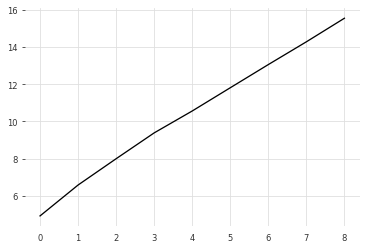

In [113]:
y = data['hosp']
lookback = 7
result = []
fh_result = []
for fh in range(1,10):
    for dep in y.zone:
        cv_result = sliding_cross_val_score(
            y.sel(zone=dep).to_pandas(),
            fh=fh,
            step_length=10,
            estimator=PolynomialTrendForecaster(degree=1)
            )
        result.append(cv_result.mean())
    print(f'La MAE moyenne des prédictions à {fh} jours est de {np.array(result).mean()}')
    fh_result.append(np.array(result).mean())
plt.plot(fh_result)

In [362]:
fh = 7
cross_val_steps = 10
def objective(trial):
    lookback = trial.suggest_int('lookback', 1, 50)
    degree = trial.suggest_int('degree', 1, 20)
    forecaster = PolynomialTrendForecaster(degree=degree)
    
    cv_result = sliding_cross_val_score(
        y,
        estimator=forecaster,
        fh=fh,
        step_length=cross_val_steps,
        lookback=lookback
    )
    
    return cv_result.mean()
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2021-08-29 23:09:17,928] A new study created in memory with name: no-name-bda68415-ad37-43b1-9cca-7087d7b2ebdc
/home/trom/.local/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2021-08-29 23:09:18,016] Trial 0 finished with value: 47040341.72766022 and parameters: {'lookback': 31, 'degree': 18}. Best is trial 0 with value: 47040341.72766022.
[I 2021-08-29 23:09:18,095] Trial 1 finished with value: 14196164752535.043 and parameters: {'lookback': 5, 'degree': 14}. Best is trial 0 with value: 47040341.72766022.
[I 2021-08-29 23:09:18,174] Trial 2 finished with value: 5640769174.053521 and parameters: {'lookback': 8, 'degree': 12}. Best is trial 0 with value: 47040341.72766022.
[I 2021-08-29 23:09:18,252] Trial 3 finished with value: 1761411878824982.5 and parameters: {'lookback': 4, 'degree': 16}. Best is trial 0 with value: 47040341.72766022.
[I 2021-08-29 23:09:18,333] Trial 4 finished with value: 1318.2399221201886 and parameters: {'lookback': 27, 'degree': 6}. Best is trial 4 with value: 1318.2399221201886.
[I 2021-08-29 23:09:18,395] Trial 5 finished with value: 372.97235532987014 and parameters: {'lookback': 47, 'degree': 6}. Best is trial 5 with value:

[I 2021-08-29 23:09:21,982] Trial 47 finished with value: 71.72413793103448 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 47 with value: 71.72413793103448.
[I 2021-08-29 23:09:22,068] Trial 48 finished with value: 73.67857142857143 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 47 with value: 71.72413793103448.
[I 2021-08-29 23:09:22,148] Trial 49 finished with value: 72.10714285714286 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 47 with value: 71.72413793103448.
[I 2021-08-29 23:09:22,229] Trial 50 finished with value: 81880406.41486521 and parameters: {'lookback': 11, 'degree': 11}. Best is trial 47 with value: 71.72413793103448.
[I 2021-08-29 23:09:22,318] Trial 51 finished with value: 74.0 and parameters: {'lookback': 1, 'degree': 13}. Best is trial 47 with value: 71.72413793103448.
[I 2021-08-29 23:09:22,414] Trial 52 finished with value: 1882625998267.4202 and parameters: {'lookback': 4, 'degree': 13}. Best is trial 47 with value: 71.7

[I 2021-08-29 23:09:26,151] Trial 92 finished with value: 128562897759698.78 and parameters: {'lookback': 3, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:26,237] Trial 93 finished with value: 263689469940432.94 and parameters: {'lookback': 2, 'degree': 16}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:26,323] Trial 94 finished with value: 72.76923076923077 and parameters: {'lookback': 1, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:26,426] Trial 95 finished with value: 206001733514.37863 and parameters: {'lookback': 4, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:26,540] Trial 96 finished with value: 613496373247.6486 and parameters: {'lookback': 6, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:26,631] Trial 97 finished with value: 4.821810496255843e+18 and parameters: {'lookback': 3, 'degree': 20}. Best is trial 91 wit

In [363]:
study.optimize(objective, n_trials=1000, n_jobs=-1)
study.trials_dataframe().sort_values('value')

/home/trom/.local/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2021-08-29 23:09:34,856] Trial 103 finished with value: 7931099856851.318 and parameters: {'lookback': 8, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:35,083] Trial 104 finished with value: 8576081741185.883 and parameters: {'lookback': 8, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:35,209] Trial 100 finished with value: 9721296510089.54 and parameters: {'lookback': 8, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:35,228] Trial 111 finished with value: 182047355383071.8 and parameters: {'lookback': 4, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:35,279] Trial 109 finished with value: 104849

[I 2021-08-29 23:09:38,963] Trial 144 finished with value: 1892268750995933.0 and parameters: {'lookback': 2, 'degree': 17}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:39,144] Trial 145 finished with value: 5261085465344.243 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:39,211] Trial 146 finished with value: 588912210824.5356 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:39,372] Trial 147 finished with value: 72.14814814814815 and parameters: {'lookback': 1, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:39,453] Trial 148 finished with value: 70.82142857142857 and parameters: {'lookback': 1, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:39,624] Trial 151 finished with value: 771556825082.3243 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 wit

[I 2021-08-29 23:09:43,804] Trial 192 finished with value: 71.11538461538461 and parameters: {'lookback': 1, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:43,929] Trial 194 finished with value: 72.44444444444444 and parameters: {'lookback': 1, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:44,122] Trial 195 finished with value: 67.8076923076923 and parameters: {'lookback': 1, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:44,190] Trial 198 finished with value: 72.10714285714286 and parameters: {'lookback': 1, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:44,220] Trial 196 finished with value: 72.14814814814815 and parameters: {'lookback': 1, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:44,252] Trial 197 finished with value: 70.96428571428571 and parameters: {'lookback': 1, 'degree': 12}. Best is trial 91 with 

[I 2021-08-29 23:09:48,671] Trial 236 finished with value: 70.82142857142857 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:48,780] Trial 238 finished with value: 74.0 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:48,961] Trial 240 finished with value: 71.5 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:48,996] Trial 228 finished with value: 2821606533.7191215 and parameters: {'lookback': 3, 'degree': 10}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:49,053] Trial 239 finished with value: 72.10714285714286 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:49,121] Trial 241 finished with value: 72.14814814814815 and parameters: {'lookback': 1, 'degree': 11}. Best is trial 91 with value: 67.8076923076923.

[I 2021-08-29 23:09:53,245] Trial 275 finished with value: 1490636886634.4587 and parameters: {'lookback': 3, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:53,465] Trial 283 finished with value: 229692871650.89746 and parameters: {'lookback': 4, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:53,629] Trial 285 finished with value: 230008405206.55344 and parameters: {'lookback': 4, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:53,664] Trial 284 finished with value: 230008405206.55344 and parameters: {'lookback': 4, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:53,736] Trial 277 finished with value: 1972574675536.5498 and parameters: {'lookback': 4, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:53,879] Trial 287 finished with value: 1558914015.7999966 and parameters: {'lookback': 2, 'degree': 10}. Best is trial 9

[I 2021-08-29 23:09:58,198] Trial 324 finished with value: 2029294615245.6199 and parameters: {'lookback': 3, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:58,244] Trial 325 finished with value: 15384813389724.416 and parameters: {'lookback': 3, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:58,263] Trial 327 finished with value: 5274894088614.644 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:58,456] Trial 326 finished with value: 4984912999962.68 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:58,687] Trial 328 finished with value: 5162161.807692323 and parameters: {'lookback': 2, 'degree': 7}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:09:58,714] Trial 331 finished with value: 6052122312582.4795 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 wit

[I 2021-08-29 23:10:03,373] Trial 372 finished with value: 3653534002.7357793 and parameters: {'lookback': 3, 'degree': 10}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:03,394] Trial 373 finished with value: 3107685695.7603755 and parameters: {'lookback': 3, 'degree': 10}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:03,509] Trial 375 finished with value: 2868374383.410935 and parameters: {'lookback': 3, 'degree': 10}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:03,545] Trial 374 finished with value: 3394084697.454749 and parameters: {'lookback': 3, 'degree': 10}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:03,706] Trial 377 finished with value: 183485598414.08862 and parameters: {'lookback': 3, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:03,745] Trial 376 finished with value: 3902712079.9410043 and parameters: {'lookback': 3, 'degree': 10}. Best is trial 91 

[I 2021-08-29 23:10:08,200] Trial 414 finished with value: 71.48148148148148 and parameters: {'lookback': 1, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:08,422] Trial 416 finished with value: 77.65384615384616 and parameters: {'lookback': 1, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:08,433] Trial 418 finished with value: 70.5 and parameters: {'lookback': 1, 'degree': 15}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:08,561] Trial 415 finished with value: 786609017219619.4 and parameters: {'lookback': 6, 'degree': 16}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:08,583] Trial 417 finished with value: 70.89285714285714 and parameters: {'lookback': 1, 'degree': 16}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:08,877] Trial 420 finished with value: 76156111887965.17 and parameters: {'lookback': 6, 'degree': 15}. Best is trial 91 with value: 67.80

[I 2021-08-29 23:10:13,144] Trial 465 finished with value: 87020430832.81482 and parameters: {'lookback': 2, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:13,336] Trial 451 finished with value: 45974905.77142183 and parameters: {'lookback': 3, 'degree': 8}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:13,401] Trial 454 finished with value: 770867081.7838551 and parameters: {'lookback': 13, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:13,443] Trial 453 finished with value: 16208606365618.025 and parameters: {'lookback': 3, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:13,544] Trial 450 finished with value: 12192221360848.408 and parameters: {'lookback': 3, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:13,696] Trial 457 finished with value: 183154232812.83603 and parameters: {'lookback': 3, 'degree': 12}. Best is trial 91 w

[I 2021-08-29 23:10:17,526] Trial 506 finished with value: 16289732123139.436 and parameters: {'lookback': 5, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:17,867] Trial 501 finished with value: 2696.0714285714253 and parameters: {'lookback': 2, 'degree': 3}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:17,913] Trial 509 finished with value: 190665364200.9362 and parameters: {'lookback': 4, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:17,936] Trial 507 finished with value: 143719779584.15918 and parameters: {'lookback': 5, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:17,940] Trial 508 finished with value: 1.2435607438015262e+16 and parameters: {'lookback': 5, 'degree': 17}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:18,085] Trial 510 finished with value: 230008405206.55344 and parameters: {'lookback': 4, 'degree': 12}. Best is trial

[I 2021-08-29 23:10:22,195] Trial 549 finished with value: 1798222512.6615407 and parameters: {'lookback': 2, 'degree': 10}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:22,329] Trial 550 finished with value: 663610568220.6785 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:22,555] Trial 551 finished with value: 4773692207038.8125 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:22,604] Trial 552 finished with value: 384.61538461538294 and parameters: {'lookback': 2, 'degree': 2}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:22,675] Trial 555 finished with value: 5274894088614.644 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:22,800] Trial 554 finished with value: 4449335683205.985 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 wi

[I 2021-08-29 23:10:26,763] Trial 594 finished with value: 1020782410.8205905 and parameters: {'lookback': 23, 'degree': 19}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:26,924] Trial 597 finished with value: 23894482920.890484 and parameters: {'lookback': 4, 'degree': 11}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:27,016] Trial 601 finished with value: 1.3552251158562808e+18 and parameters: {'lookback': 4, 'degree': 19}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:27,161] Trial 595 finished with value: 211853172993.1881 and parameters: {'lookback': 4, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:27,220] Trial 602 finished with value: 209951532785.59534 and parameters: {'lookback': 3, 'degree': 12}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:27,377] Trial 603 finished with value: 467233.4210754633 and parameters: {'lookback': 42, 'degree': 12}. Best is tri

[I 2021-08-29 23:10:31,895] Trial 637 finished with value: 5077628041916.075 and parameters: {'lookback': 2, 'degree': 14}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:32,054] Trial 641 finished with value: 612757657485.6239 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:32,189] Trial 640 finished with value: 728670427817.855 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:32,367] Trial 644 finished with value: 588912210824.5356 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:32,480] Trial 647 finished with value: 728670427817.855 and parameters: {'lookback': 2, 'degree': 13}. Best is trial 91 with value: 67.8076923076923.
[I 2021-08-29 23:10:32,513] Trial 646 finished with value: 365965.5871738397 and parameters: {'lookback': 46, 'degree': 13}. Best is trial 91 with 

[I 2021-08-29 23:10:37,093] Trial 685 finished with value: 10705.680000000058 and parameters: {'lookback': 5, 'degree': 4}. Best is trial 675 with value: 55.24814814814832.
[I 2021-08-29 23:10:37,105] Trial 683 finished with value: 69.64285714285714 and parameters: {'lookback': 1, 'degree': 1}. Best is trial 675 with value: 55.24814814814832.
[I 2021-08-29 23:10:37,406] Trial 688 finished with value: 5669.273515578455 and parameters: {'lookback': 6, 'degree': 4}. Best is trial 675 with value: 55.24814814814832.
[I 2021-08-29 23:10:37,420] Trial 686 finished with value: 56.451851851851785 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 675 with value: 55.24814814814832.
[I 2021-08-29 23:10:37,545] Trial 689 finished with value: 173594.288417081 and parameters: {'lookback': 10, 'degree': 7}. Best is trial 675 with value: 55.24814814814832.
[I 2021-08-29 23:10:37,561] Trial 687 finished with value: 71.48148148148148 and parameters: {'lookback': 1, 'degree': 1}. Best is trial 6

[I 2021-08-29 23:10:41,428] Trial 732 finished with value: 163.08994708994626 and parameters: {'lookback': 7, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:41,442] Trial 730 finished with value: 139.36263736263734 and parameters: {'lookback': 7, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:41,565] Trial 723 finished with value: 116.08624708624532 and parameters: {'lookback': 9, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:41,675] Trial 733 finished with value: 113.42500000000283 and parameters: {'lookback': 8, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:41,783] Trial 734 finished with value: 147.26999999999754 and parameters: {'lookback': 8, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:41,812] Trial 727 finished with value: 108.58999999999776 and parameters: {'lookback': 8, 'degree': 2}. Best is tri

[I 2021-08-29 23:10:46,217] Trial 780 finished with value: 56.57742504409178 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:46,314] Trial 779 finished with value: 58.012571428571384 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:46,365] Trial 781 finished with value: 64.55837742504413 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:46,526] Trial 769 finished with value: 58.37499999999981 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:46,607] Trial 771 finished with value: 61.11538461538473 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:46,679] Trial 770 finished with value: 63.807692307692534 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 7

[I 2021-08-29 23:10:51,074] Trial 823 finished with value: 168.41556122449248 and parameters: {'lookback': 6, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:51,078] Trial 821 finished with value: 173.8788359788375 and parameters: {'lookback': 6, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:51,268] Trial 822 finished with value: 205.51190476190797 and parameters: {'lookback': 6, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:51,283] Trial 814 finished with value: 96.79745454545315 and parameters: {'lookback': 10, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:51,392] Trial 815 finished with value: 113.15559440559628 and parameters: {'lookback': 10, 'degree': 2}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:51,416] Trial 825 finished with value: 1071.9120879120853 and parameters: {'lookback': 6, 'degree': 3}. Best is tri

[I 2021-08-29 23:10:56,171] Trial 864 finished with value: 465.6820202017604 and parameters: {'lookback': 9, 'degree': 3}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:56,314] Trial 869 finished with value: 60.92711111111101 and parameters: {'lookback': 9, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:56,367] Trial 865 finished with value: 419.26056864960765 and parameters: {'lookback': 9, 'degree': 3}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:56,463] Trial 866 finished with value: 65.72466666666662 and parameters: {'lookback': 9, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:56,548] Trial 868 finished with value: 57.88796296296284 and parameters: {'lookback': 9, 'degree': 1}. Best is trial 705 with value: 50.32000000000019.
[I 2021-08-29 23:10:56,568] Trial 867 finished with value: 67.42222222222217 and parameters: {'lookback': 9, 'degree': 1}. Best is trial 70

[I 2021-08-29 23:11:00,846] Trial 901 finished with value: 54.89423076923087 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:00,899] Trial 911 finished with value: 178.66031746031555 and parameters: {'lookback': 5, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:00,938] Trial 902 finished with value: 58.64814814814799 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:01,000] Trial 905 finished with value: 152.46031746031767 and parameters: {'lookback': 7, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:01,187] Trial 915 finished with value: 199.84515306122734 and parameters: {'lookback': 6, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:01,203] Trial 914 finished with value: 199.52799999999598 and parameters: {'lookback': 5, 'degree': 2}. Best is trial

[I 2021-08-29 23:11:05,749] Trial 951 finished with value: 55.421428571428486 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:05,823] Trial 950 finished with value: 70.97500000000001 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:05,962] Trial 955 finished with value: 57.15000000000017 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:06,048] Trial 954 finished with value: 60.71538461538463 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:06,150] Trial 952 finished with value: 70.97500000000001 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:06,165] Trial 959 finished with value: 57.15000000000017 and parameters: {'lookback': 5, 'degree': 1}. Best is trial 88

[I 2021-08-29 23:11:10,801] Trial 1000 finished with value: 71.77210884353755 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:10,830] Trial 1003 finished with value: 80.17116343014347 and parameters: {'lookback': 23, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:10,959] Trial 996 finished with value: 70.64212454212468 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:11,179] Trial 1006 finished with value: 273.2910714285671 and parameters: {'lookback': 4, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:11,210] Trial 1005 finished with value: 325.61249999999893 and parameters: {'lookback': 4, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:11,376] Trial 999 finished with value: 58.5450549450549 and parameters: {'lookback': 6, 'degree': 1}. Best is tria

[I 2021-08-29 23:11:15,412] Trial 1043 finished with value: 61.3202222222222 and parameters: {'lookback': 9, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:15,437] Trial 1044 finished with value: 59.27777777777783 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:15,692] Trial 1046 finished with value: 53.89904761904755 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:15,702] Trial 1045 finished with value: 61.10576923076939 and parameters: {'lookback': 8, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:15,811] Trial 1049 finished with value: 58.5450549450549 and parameters: {'lookback': 6, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:15,975] Trial 1050 finished with value: 84.62749264465516 and parameters: {'lookback': 20, 'degree': 1}. Best is tria

[I 2021-08-29 23:11:20,237] Trial 1088 finished with value: 151.45879120879118 and parameters: {'lookback': 7, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:20,307] Trial 1090 finished with value: 142.95743219834003 and parameters: {'lookback': 45, 'degree': 2}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:20,456] Trial 1095 finished with value: 62.44571428571427 and parameters: {'lookback': 7, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:20,523] Trial 1096 finished with value: 60.08994708994716 and parameters: {'lookback': 7, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:20,676] Trial 1099 finished with value: 69.8650793650795 and parameters: {'lookback': 7, 'degree': 1}. Best is trial 886 with value: 48.53066666666671.
[I 2021-08-29 23:11:20,743] Trial 1097 finished with value: 59.465714285714185 and parameters: {'lookback': 7, 'degree': 1}. Best is 

,number,value,datetime_start,datetime_complete,duration,params_degree,params_lookback,state
886,886,4.853067e+01,2021-08-29 23:10:57.395294,2021-08-29 23:10:58.378952,0 days 00:00:00.983658,1,6,COMPLETE
887,887,4.853067e+01,2021-08-29 23:10:57.501386,2021-08-29 23:10:58.646589,0 days 00:00:01.145203,1,6,COMPLETE
928,928,4.853067e+01,2021-08-29 23:11:01.900980,2021-08-29 23:11:03.012482,0 days 00:00:01.111502,1,6,COMPLETE
946,946,4.924400e+01,2021-08-29 23:11:03.947917,2021-08-29 23:11:05.477037,0 days 00:00:01.529120,1,5,COMPLETE
705,705,5.032000e+01,2021-08-29 23:10:38.204028,2021-08-29 23:10:38.969264,0 days 00:00:00.765236,1,7,COMPLETE
...,...,...,...,...,...,...,...,...
601,601,1.355225e+18,2021-08-29 23:10:26.541703,2021-08-29 23:10:27.016155,0 days 00:00:00.474452,19,4,COMPLETE
596,596,4.022583e+18,2021-08-29 23:10:26.216135,2021-08-29 23:10:27.894797,0 days 00:00:01.678662,20,3,COMPLETE
97,97,4.821810e+18,2021-08-29 23:09:26.540894,2021-08-29 23:09:26.631321,0 days 00:00:00.090427,20,3,COMPLETE
532,532,4.957192e+18,2021-08-29 23:10:19.701465,2021-08-29 23:10:20.499986,0 days 00:00:00.798521,20,3,COMPLETE


La valeur optimale semble être une approximation linéaire avec un lookback entre 5 et 7, ce qui paraît très raisonnable ! (pour une erreur de 50 environ)

# Univariate Arima.

Essayons maintenant avec un modèle qui pourrait bénificier d'une cross validation avec des expanding windows.

In [418]:
initial_shift=30
step_length=10
number_of_folds=0
ews =  ExpandingWindowSplitter(fh=fh, initial_window=initial_shift)
window_generator = ews._split_windows(
    start=step_length+np.random.randint(0, initial_shift),
    end=len(y)-fh,
    step_length=step_length,
    window_length=step_length,
    fh=fh,
)

for train, test in window_generator:
    number_of_folds += 1
    print(test)
print(f'number of temporal expanding folds is {number_of_folds}')

22
32
42
52
62
72
82
92
102
112
122
132
142
152
162
172
182
192
202
212
222
232
242
252
262
272
282
292
302
312
number of temporal expanding folds is 30


In [429]:
def expanding_cross_val_score(
    y,
    estimator=None,
    fh=1,
    step_length= 10,
    initial_shift=30,
    verbose=False
) -> np.array:
    # On crée un générateur de fenêtre glissante (on prend un entier)
    ews =  ExpandingWindowSplitter(fh=fh, initial_window=initial_shift)
    window_generator = ews._split_windows(
        start=initial_shift,
        end=len(y)-fh,
        step_length=step_length,
        window_length=step_length,
        fh=fh,
    )
        
    # On itere sur les splits que ça génère 
    cross_val_score = []
    number_of_folds = 0
    for train, test in window_generator:
        number_of_folds += 1
        train, test = y.iloc[train], y.iloc[test]
        estimator.fit(train, fh=fh)
        y_pred = estimator.predict()
        cross_val_score.append(abs(test - y_pred)) 
    
    if verbose:
        print(f'number of expanding temporal folds: {number_of_folds}')
    return np.array(cross_val_score)

In [430]:
from sktime.forecasting.arima import AutoARIMA
arima = AutoARIMA()
cv_result = expanding_cross_val_score(
    y, fh=7, estimator=arima,
    initial_shift=30,
    step_length=20)

In [431]:
cv_result.mean()

76.58280203510344